## Discriminator | multilayer perceptron

We use mnist dataset.

Assume that images of ONE are REAL(1), and those of SEVEN are FAKE(0).

We investigate whether a Discriminator can discriminate ONE from SEVEN.

<img src="https://docs.google.com/uc?id=1XXmgT15DAbcN1tNI8OvefeTdq4cevU40" width="300">


<img src="https://docs.google.com/uc?id=1RyU-ML85aiOLyT1BnmKSwdhqeC-AyqNV" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/miokobayashii/summerschool2022/blob/main/day01/Practice04_Discriminator_NN.ipynb)

In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
#from tensorflow.keras.utils import plot_model

In [38]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)    

### Disctiminator

As an input layer, Flatten layer is used.

In [41]:
def build_discriminator(img_shape):

    model = Sequential()

    # Flatten the input image
    model.add(Flatten(input_shape=img_shape))
    
    # Fully connected layer
    model.add(Dense(128))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               100480    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


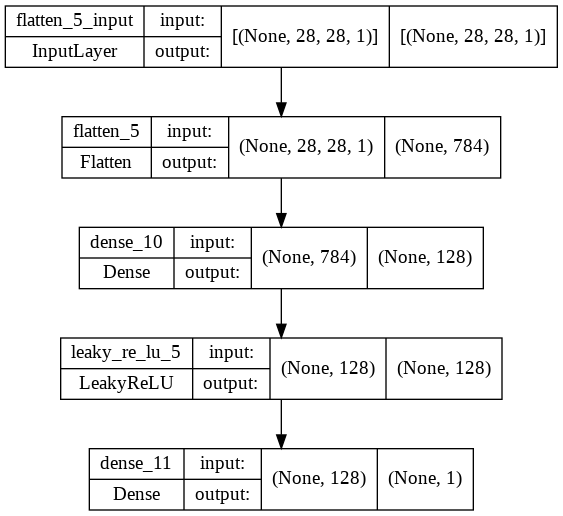

In [90]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam_v2.Adam(),
                      metrics=['accuracy'])
discriminator.summary()
plot_model(discriminator, to_file='model.png', show_shapes=True)


### Load MNIST dataset and confirm images of handwritten digits

In [44]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [46]:
def show_img(img, figsize=(2,2)):
    fig = plt.figure(figsize=figsize,dpi=100)
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

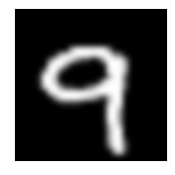

In [47]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
char = 9
X_test = X_test[np.where(y_test==char)]  
[idx] = np.random.randint(0, X_test.shape[0], 1)
show_img(X_test[idx])

In [48]:
for i in range(28):
  for j in range(28):
    s = str(X_test[idx][i][j])
    s_ljust = s.rjust(4,'_')
    print(s_ljust, end="")
  
  print("")

___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0___0___0___0_176_254_255_254_254_254_251_131___6___0___0___0___0___0___0___0___0___0
___0___0___0___0___0___0___0__34_194_221_248_254_254_252_225_241_254_254_136_124__11___0___0___0

### Trainning process
In Practice02_DefineLossFunctionOptimizer.ipynb, we used "model.fit()" to train the model, but here we use iterations and "discriminator.train_on_batch()" instead. That is because we can extend the program to train a generator network later.

In [91]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(batch_size, sample_interval, n_epochs = 1):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    char = 1 #True image
    X_train_1 = X_train[np.where(y_train==char)]    

    char = 7 #Fake image
    X_train_7 = X_train[np.where(y_train==char)]  

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train_1 = X_train_1 / 127.5 - 1.0
    X_train_7 = X_train_7 / 127.5 - 1.0

    #for iteration in range(iterations):
    bat_per_epo = int((X_train_1.shape[0] + X_train_7.shape[0]) / batch_size)
    half_batch = int(batch_size / 2)
    print(bat_per_epo, half_batch )
    # Labels for real images: all ones
    real = np.ones((half_batch, 1))
    # Labels for fake images: all zeros
    fake = np.zeros((half_batch, 1))

    for i in range(n_epochs):
        for j in range(bat_per_epo):

          # -------------------------
          #  Train the Discriminator
          # -------------------------

          # Get a random batch of real images
          idx = np.random.randint(0, X_train_1.shape[0], half_batch)
          imgs = X_train_1[idx]

          # Get a random batch of fake images
          idx = np.random.randint(0, X_train_7.shape[0], half_batch)
          fake_img = X_train_7[idx]

          # Train Discriminator
          d_loss_real = discriminator.train_on_batch(imgs, real)
          d_loss_fake = discriminator.train_on_batch(fake_img , fake)
          # print(d_loss_real, d_loss_fake)
          d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)


          if (i*10 +  j + 1) % sample_interval == 0 :

                # Save losses and accuracies so they can be plotted after training
                losses.append((d_loss))
                accuracies.append(100.0 * accuracy)
                iteration_checkpoints.append(i*10 +  j + 1)

                # Output training progress
                print("Epoch:%d %d/%d [D loss: %f, acc.: %.2f%%]" %
                      (i + 1, j+1, bat_per_epo, d_loss, 100.0 * accuracy))
 

In [ ]:
discriminator.metrics_names

[]

In [ ]:
# Set hyperparameters
batch_size = 128
sample_interval = 10

# Train the Discriminator for the specified number of iterations
train(batch_size, sample_interval)

### Evaluation

In [93]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
char = 1 #True image: A label for 1 is "1"
X_test_1 = X_test[np.where(y_test==char)]    
y_test_1 = y_test[np.where(y_test==char)]  
y_test_1 = np.ones((y_test_1.shape[0], 1))

char = 7 #Fake image: A label for 7 is "0"
X_test_7 = X_test[np.where(y_test==char)]  
y_test_7 = y_test[np.where(y_test==char)]  
y_test_7 = np.zeros((y_test_7.shape[0], 1))

In [ ]:
_, accuracy = discriminator.evaluate(X_test_1, y_test_1)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

In [ ]:
_, accuracy = discriminator.evaluate(X_test_7, y_test_7)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

In [ ]:
#fake_img = np.zeros((batch_size, 28, 28)) -1
 #fake_img = np.random.normal(-1, 1, (batch_size, 28, 28))
(X_train, _), (X_test, _) = mnist.load_data()
char = 1 #True image
X_test_1 = X_test[np.where(y_test==char)]    

char = 7 #Fake image
X_test_7 = X_test[np.where(y_test==char)]  

test_size = 20

#### test 1: real image
idx = np.random.randint(0, X_test_1.shape[0], test_size)
imgs_1 = X_test_1[idx]

for i in range(test_size):
  print(i, end=" ")
  show_img(imgs_1[i])

y = discriminator.predict(imgs_1)
print(y)

false = np.where(y<=0.5)
print(false)


#### test 7: fake image
idx = np.random.randint(0, X_test_7.shape[0], test_size)
imgs_7 = X_test_7[idx]

for i in range(test_size):
  print(i, end=" ")
  show_img(imgs_7[i])

y = discriminator.predict(imgs_7)
print(y)

false = np.where(y>=0.5)
print(false)

In [ ]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")


plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()